<font size="5">**Importing necessary libraries, setting up document**

https://course.fast.ai/videos/?lesson=1

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# The notebook reloads automatically, have plots stored in document

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

import pandas as pd # Data processing
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
# Import some libraries to use

<font size="5">**Preparing data for the model**

In [3]:
data_folder = Path("../input/aptos2019-blindness-detection")
data_folder.ls()
# Allows for the manipulation of folders, see file structure used

[PosixPath('../input/aptos2019-blindness-detection/test_images'),
 PosixPath('../input/aptos2019-blindness-detection/test.csv'),
 PosixPath('../input/aptos2019-blindness-detection/train_images'),
 PosixPath('../input/aptos2019-blindness-detection/train.csv'),
 PosixPath('../input/aptos2019-blindness-detection/sample_submission.csv')]

In [4]:
train_df = pd.read_csv(data_folder/'train.csv')
test_df = pd.read_csv(data_folder/'sample_submission.csv')
# Read data into the dataframes for training and testing, allows for easy manipulation of the data

https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4
https://docs.fast.ai/data_block.html

In [5]:
test_data = ImageList.from_df(test_df, path=data_folder, folder='test_images', suffix='.png')
# Object to represent test set, using data block API

In [6]:
bs = 64
#Set batch size

In [7]:
# Data block API, prepares data for training, use in the model 
data = (ImageList.from_df(train_df, path=data_folder, folder='train_images', suffix = '.png')
                 .split_by_rand_pct(valid_pct=0.1) #split between training, validation sets
                 .label_from_df()
                 .add_test(test_data)              
                 .transform(get_transforms(flip_vert=True), size=224)
                 .databunch(path='.', bs=bs) #use bs from earlier
                 .normalize(imagenet_stats)
       )

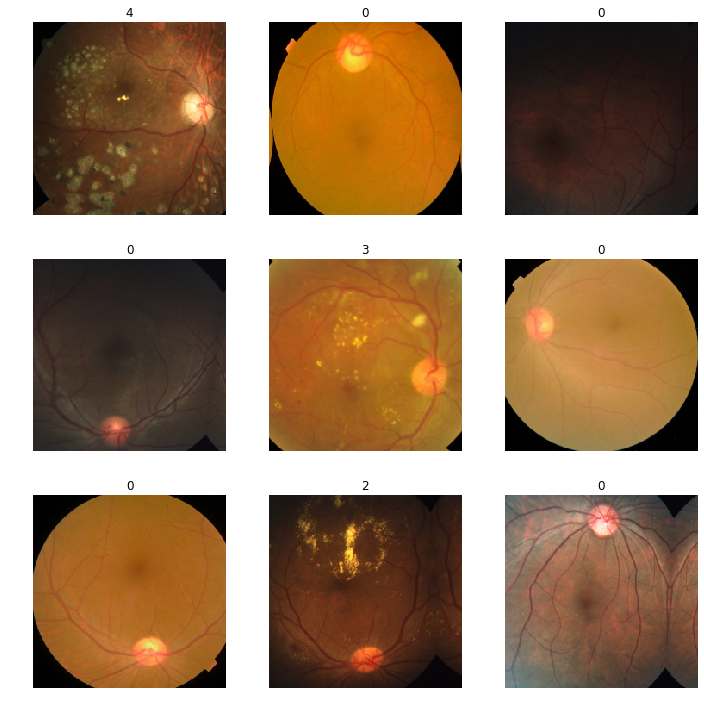

In [8]:
data.show_batch(rows=3, figsize=(10,10))
# See some of the images we are working with

<font size="5">**Training, running the model**

In [9]:
# Create the learner for a convolutional neural network
learn = cnn_learner(data, models.resnet34, pretrained=False, model_dir = "/output/kaggle/working", metrics=error_rate)

https://www.kaggle.com/tanlikesmath/oversampling-mnist-with-fastai

https://docs.fast.ai/callbacks.lr_finder.html#LRFinder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 1.20E-02


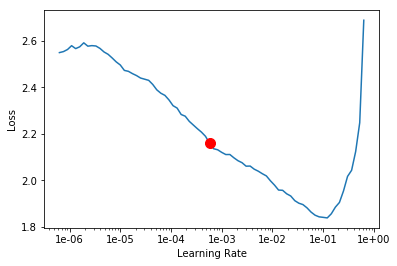

In [10]:
# Find optimal learning rate to use for the model
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.0005754399373371565

In [12]:
learn.fit_one_cycle(5, min_grad_lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.716172,0.998141,0.262295,08:26
1,1.456507,0.939526,0.254098,08:14
2,1.255059,0.824050,0.256831,08:16
3,1.166625,0.794991,0.254098,08:19
4,1.084375,0.773366,0.251366,08:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-07


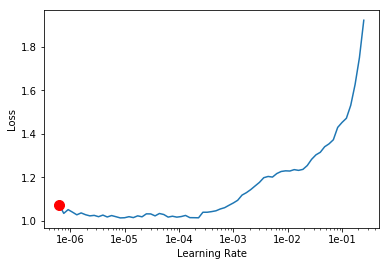

In [13]:
#Retrain model and fine-tune the learning rate
learn.save('initial') # Set of weights created with learn, saves the model for possible future use/access
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [14]:
# Fine-tuning, new learning rate
min_grad_lr2 = learn.recorder.min_grad_lr
min_grad_lr2

6.309573444801933e-07

<font size="5">**Results**

In [15]:
learn.fit_one_cycle(10, min_grad_lr2)

epoch,train_loss,valid_loss,error_rate,time
0,1.047789,0.773775,0.254098,08:13
1,1.027683,0.769926,0.251366,08:15
2,1.029346,0.762914,0.245902,08:13
3,1.040004,0.768809,0.251366,08:17
4,1.027096,0.767156,0.243169,08:31
5,1.019814,0.762903,0.248634,08:16
6,1.032758,0.770748,0.251366,08:14
7,1.026401,0.762995,0.245902,08:08
8,1.040201,0.761676,0.240437,08:03
9,1.024740,0.762507,0.243169,08:06


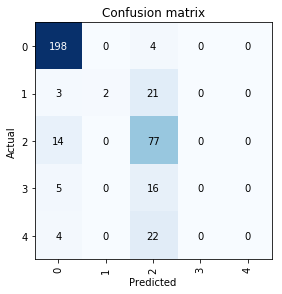

In [16]:
learn.save('final')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix() # A way to display the "accuracy"

<font size="5">**Predicting, submitting**

Some code to get the predictions, and place them in a .csv file we can view, to see the diagnoses

In [17]:
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# Output predictions to the file
test_df.to_csv('submission_preds.csv', index=False)